In [1]:
# 在本机未更新至2.0.8的情况下，使用vnpy2.0.8的回测逻辑
import sys
import os
from pathlib import Path
new_version_path = Path(os.getenv('VNPY2.0.8'))
sys.path.insert(0, str(new_version_path))

import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

from datetime import datetime
from research_backtest import get_hot_start, run_research_backtest, batch_run, analyze_multi_bt, str_to_params, params_to_str
from utility import get_output_folder, get_output_path

2.0.8


#### 单品种回测及成交记录分析

In [ ]:
commodity = 'rb'
strategy_name = 'entry_50_following_stop'
start = get_hot_start(commodity)
end = datetime(2019, 12, 1)
params_dict = {
    'entry_window': 50,
#     'exit_window': 20,
    'sl_multiplier': 3
}

res_dict = run_research_backtest(commodity, start, end, strategy_name, params_dict, trade_output=True, curve_output=True)
res_dict

params_str = params_to_str(params_dict)
filename = f'{strategy_name}.{commodity}.{params_str}.default.trades.csv'
trades = pd.read_csv(get_output_path(filename, 'trades'))
cum_pnl = 0
for idx, trade in trades.iterrows():
    print(f"{trade.vt_symbol} \t {trade.datetime} \t {trade.direction} \t {trade.price}")
    if trade.offset == "open":
        entry = trade.price
        volume = 1 if trade.direction == "long" else -1
    
    if trade.offset == "close":
        pnl = (trade.price - entry) * volume
        cum_pnl += pnl
        print(f"Trade Pnl: {pnl} \t Cum Pnl: {cum_pnl}")
        print("=" * 60)
        print("\n")

### 统计多品种回测结果

In [26]:
note = 'entry_80_exit_ma_stop_atr'
params_sep_str = '.'

folder = get_output_folder('multi_backtest', note)
files = list(folder.glob(f'*.csv'))

res_list = []
columns = []
for file in files:
    res = analyze_multi_bt(file.name, note)
    res_list.append(res)
    columns = list(res.keys())

df = pd.DataFrame(res_list, columns=columns)
df['note'] = df['test_name'].map(lambda x: x.split('@')[-1])

# 添加参数列，用于筛选
df = df[df['note'] == note]

params_dict_list = [str_to_params(name.split('@')[1], sep=params_sep_str) for name in df['test_name']]
params_df = pd.DataFrame(params_dict_list, index=df.index)
df = pd.concat([df, params_df], axis=1)

df

# show_items = ['annual_mean', 'all_invest', 'sharpe_mean', 'max_dd', 'win_mean', 'win_to_loss']
# pivoted = df.pivot('exit_window', 'stop_multiple', show_items)
# pivoted = df.pivot('entry_window', 'exit_window', show_items)

df
# pivoted['sharpe_mean']
# sel = df[df['stop_multiple']==7]
# sel.sort_values(by='exit_window')

,test_name,all_invest,daily_trade,win,loss,win_rate,annual_mean,max_dd,best_rtn,worst_rtn,...,worst_ddp,sharpe_mean,win_mean,win_to_loss,cost_ratio,pos_duration,note,entry_window,exit_window,stop_multiple
0,turtle_exit_ma@entry_window_80.exit_window_30....,7625,9.904255,16,21,0.432432,-0.022022,-16.329018,100.275131,-53.043704,...,-54.698455,-0.084029,0.338962,1.916219,0.620743,97.126231,entry_80_exit_ma_stop_atr,80.0,30.0,10.0
1,turtle_exit_ma@entry_window_80.exit_window_30....,9933,12.922552,12,25,0.324324,-0.963229,-18.493228,80.785079,-67.032963,...,-67.201027,-0.264607,0.233443,2.970324,1.348531,58.049302,entry_80_exit_ma_stop_atr,80.0,30.0,1.0
2,turtle_exit_ma@entry_window_80.exit_window_30....,8060,10.450794,14,23,0.378378,-0.440831,-17.205394,87.575714,-57.857037,...,-59.084397,-0.154864,0.315316,2.055108,0.773729,86.286319,entry_80_exit_ma_stop_atr,80.0,30.0,2.0
3,turtle_exit_ma@entry_window_80.exit_window_30....,7695,9.984628,15,22,0.405405,-0.135817,-16.641549,94.549215,-52.562222,...,-54.228492,-0.099968,0.335757,1.923444,0.639997,94.891158,entry_80_exit_ma_stop_atr,80.0,30.0,3.0
4,turtle_exit_ma@entry_window_80.exit_window_30....,7634,9.914530,16,21,0.432432,-0.020880,-16.321512,101.210246,-53.043704,...,-54.698455,-0.085319,0.338637,1.918179,0.612286,96.755785,entry_80_exit_ma_stop_atr,80.0,30.0,4.0
5,turtle_exit_ma@entry_window_80.exit_window_30....,7628,9.906829,16,21,0.432432,-0.012429,-16.286450,100.427803,-53.043704,...,-54.698455,-0.082426,0.338874,1.918630,0.620109,97.030458,entry_80_exit_ma_stop_atr,80.0,30.0,5.0
6,turtle_exit_ma@entry_window_80.exit_window_30....,7627,9.905881,16,21,0.432432,-0.017129,-16.304379,100.275131,-53.043704,...,-54.698455,-0.083276,0.338901,1.917316,0.626456,97.077331,entry_80_exit_ma_stop_atr,80.0,30.0,6.0
7,turtle_exit_ma@entry_window_80.exit_window_30....,7627,9.905881,16,21,0.432432,-0.023887,-16.314361,100.275131,-53.043704,...,-54.698455,-0.084359,0.338901,1.915942,0.630287,97.084448,entry_80_exit_ma_stop_atr,80.0,30.0,7.0
8,turtle_exit_ma@entry_window_80.exit_window_30....,7626,9.905009,16,21,0.432432,-0.022127,-16.318883,100.275131,-53.043704,...,-54.698455,-0.084013,0.338931,1.916404,0.625657,97.112050,entry_80_exit_ma_stop_atr,80.0,30.0,8.0
9,turtle_exit_ma@entry_window_80.exit_window_30....,7626,9.905009,16,21,0.432432,-0.023601,-16.324248,100.275131,-53.043704,...,-54.698455,-0.084262,0.338931,1.916112,0.626316,97.112526,entry_80_exit_ma_stop_atr,80.0,30.0,9.0


#### 双变量概览

In [ ]:
# 展示热力图
%matplotlib notebook
plt.rcParams.update({'font.size': 8})
import seaborn as sns

show_items = ['annual_mean', 'all_invest', 'sharpe_mean', 'max_dd', 'win_mean', 'win_to_loss']

plt.figure(figsize=(10, 12))

annual_plot = plt.subplot(3, 2, 1)
annual_plot.set_title("Annual Return Mean")
sns.heatmap(pivoted['annual_mean'], fmt='d', linewidths=.5, cmap='YlGnBu')

invest_plot = plt.subplot(3, 2, 2)
invest_plot.set_title('Invest count')
sns.heatmap(pivoted['all_invest'], fmt='d', linewidths=.5, cmap='YlGnBu')

sharpe = plt.subplot(3, 2, 3)
sharpe.set_title('Sharpe Ratio Mean')
sns.heatmap(pivoted['sharpe_mean'], fmt='d', linewidths=.5, cmap='YlGnBu')

drawdown_plot = plt.subplot(3, 2, 4)
drawdown_plot.set_title('Max drawdown percent Mean')
sns.heatmap(pivoted['max_dd'], fmt='d', linewidths=.5, cmap='YlGnBu')

win_plot = plt.subplot(3, 2, 5)
win_plot.set_title('Winning rate Mean')
sns.heatmap(pivoted['win_mean'], fmt='d', linewidths=.5, cmap='YlGnBu')

win_to_loss_plot = plt.subplot(3, 2, 6)
win_to_loss_plot.set_title('Win to loss mean ')
sns.heatmap(pivoted['win_to_loss'], fmt='d', linewidths=.5, cmap='YlGnBu')

plt.tight_layout(pad=4) 

#### 单变量分析

In [27]:
df_single = df.copy()

fixed_var = 'entry_window'
fixed_var_value = 80
# analyze_var = 'sl_multiplier'
analyze_var = 'stop_multiple'


df_single = df_single[df_single[fixed_var] == fixed_var_value]
# df_single = df_single[df_single[analyze_var] >= 3]
df_single.set_index(analyze_var, inplace=True)


# df_single = df_single[df_single['stop_multiple'] == 4]
# df_single.set_index('exit_window', inplace=True)

# df_single.set_index('stop_multiple', inplace=True)
df_single.sort_index(inplace=True)
# df_single

<IPython.core.display.Javascript object>


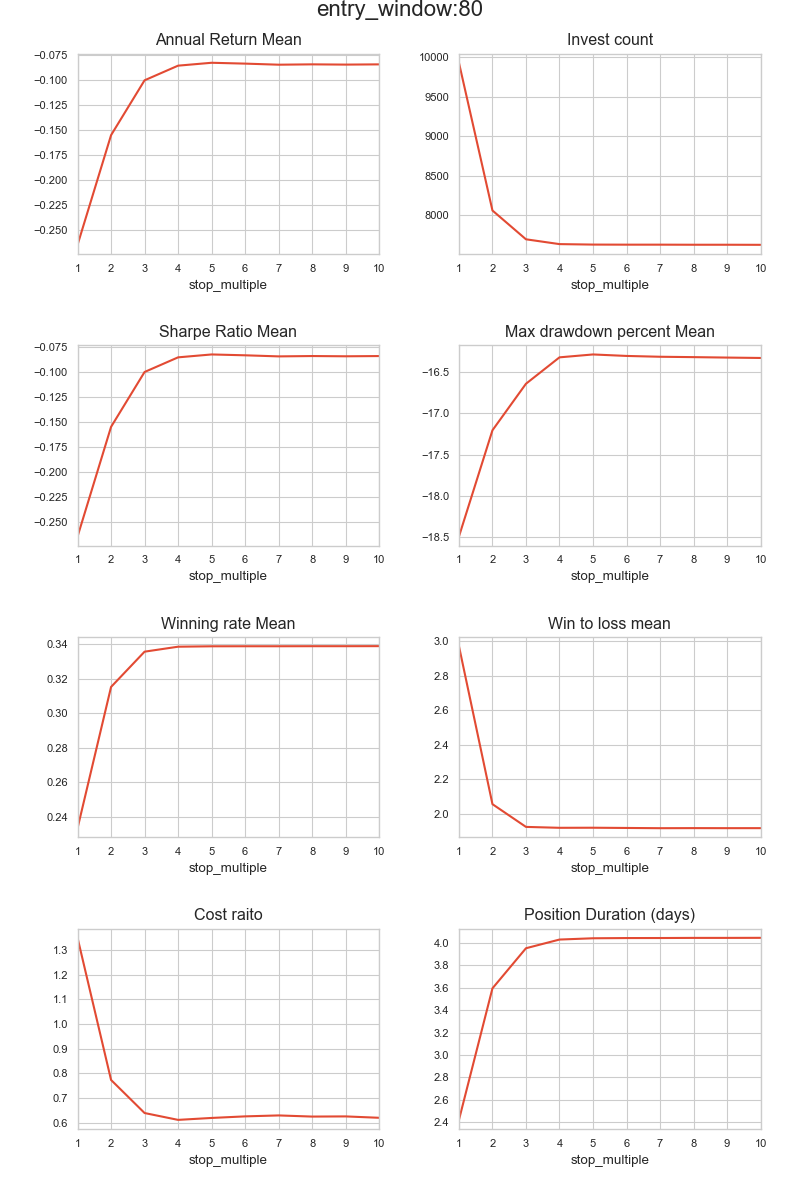

In [28]:
%matplotlib notebook
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(8, 12))
fig.suptitle(f'{fixed_var}:{fixed_var_value}', fontsize=16, y=1)

annual_plot = plt.subplot(4, 2, 1)
annual_plot.set_title("Annual Return Mean")
df_single['sharpe_mean'].plot()

invest_plot = plt.subplot(4, 2, 2)
invest_plot.set_title('Invest count')
df_single['all_invest'].plot()

sharpe = plt.subplot(4, 2, 3)
sharpe.set_title('Sharpe Ratio Mean')
df_single['sharpe_mean'].plot()

drawdown_plot = plt.subplot(4, 2, 4)
drawdown_plot.set_title('Max drawdown percent Mean')
df_single['max_dd'].plot()

win_plot = plt.subplot(4, 2, 5)
win_plot.set_title('Winning rate Mean')
df_single['win_mean'].plot()

win_to_loss_plot = plt.subplot(4, 2, 6)
win_to_loss_plot.set_title('Win to loss mean')
df_single['win_to_loss'].plot()

cost_ratio_plot = plt.subplot(4, 2, 7)
cost_ratio_plot.set_title('Cost raito')
df_single['cost_ratio'].plot()

pos_duration_plot = plt.subplot(4, 2, 8)
pos_duration_plot.set_title('Position Duration (days)')
df_single['pos_duration'] /= 24
df_single['pos_duration'].plot()

plt.tight_layout(pad=3)
